In [12]:
dstype = 'stress' 
mname = 'debertaV3'

In [13]:
 
modelpath = 'microsoft/deberta-v3-base'
# modelpath = "bert-base-uncased"


datapath = None
saveDIR = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"
print(saveDIR)
# %%

/home/bhairavi/om/om5/stress/debertaV3_stress


In [14]:


# %%
# %%
 
import os
import torch  

torch.cuda.empty_cache() 

import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 

 


# %%
 


In [15]:
df = pd.read_csv('/home/bhairavi/om/om4/stress/Stress.csv')




In [16]:

# %%

# %%
df.sample(5)


# %%


,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
2113,assistance,5zclnp,"(2, 7)","His medical equipment (wheelchair, Hoyer lift,...",0,1.0,1489503691
829,anxiety,6qpj1p,"[0, 5]","Hi, this is my first Reddit post. I have searc...",0,0.8,1501518426
120,ptsd,8vxt7z,"(8, 13)","Strangely enough, I had buried all this. But w...",1,1.0,1530668930
1859,relationships,7txy81,"(45, 50)","She keeps using the phrase ""right now"". Whenev...",0,0.6,1517281209
2507,relationships,7s7iw5,"[10, 15]","3. Since we are both the only child, we both f...",0,0.6,1516643642


In [17]:
df['label'] = df['subreddit']

10

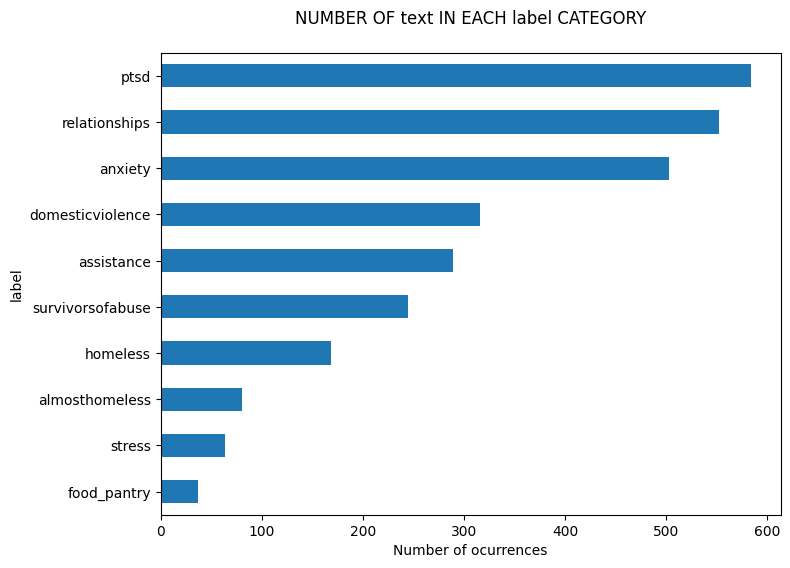

In [18]:


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


In [19]:
df.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'label', 'confidence',
       'social_timestamp', 'target'],
      dtype='object')

In [20]:
numlabel = df['target'].nunique()
numlabel


10

In [21]:
df['text'] = df['text'].apply(lambda x: x[:512])

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

/home/bhairavi/om/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/bhairavi/om/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint 

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [23]:
df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Calculate the maximum token length
max_length = df['token_length'].max()

# Calculate the next maximum token length
next_max_token_length = df['token_length'].nlargest(2).iloc[1]

# Calculate the average token length
average_token_length = df['token_length'].mean()

# Display the results
print(f"Maximum token length: {max_length}")
print(f"Next maximum token length: {next_max_token_length}")
print(f"Average token length: {average_token_length:.2f}")

Maximum token length: 257
Next maximum token length: 185
Average token length: 94.10


In [24]:

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)




Map: 100%|██████████| 142/142 [00:00<00:00, 3059.49 examples/s]


In [33]:


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 


# %%

# %%
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()

 
 



/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.413200,1.778139,0.555723,0.562557,0.560494
2,0.229000,2.004299,0.566566,0.564985,0.572840
3,0.650200,2.028483,0.581208,0.593973,0.577778


/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=861, training_loss=0.4212846079371809, metrics={'train_runtime': 174.9279, 'train_samples_per_second': 39.29, 'train_steps_per_second': 4.922, 'total_flos': 907794578029788.0, 'train_loss': 0.4212846079371809, 'epoch': 3.0})

In [34]:
save_directory = saveDIR
 

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer (optional, but recommended)
tokenizer.save_pretrained(save_directory)

('/home/bhairavi/om/om5/stress/debertaV3_stress/tokenizer_config.json',
 '/home/bhairavi/om/om5/stress/debertaV3_stress/special_tokens_map.json',
 '/home/bhairavi/om/om5/stress/debertaV3_stress/spm.model',
 '/home/bhairavi/om/om5/stress/debertaV3_stress/added_tokens.json',
 '/home/bhairavi/om/om5/stress/debertaV3_stress/tokenizer.json')

In [35]:

# %%
from colorama import Fore, Style


# %% [markdown]
# eval dataset performance so that keywords_classes can be fixed

# %%
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)
print(Fore.CYAN,"keywords class evaluation detection RESULTS")
print(report)


# %% [markdown]
# skyline

# %%


 keywords class evaluation detection RESULTS
                  precision    recall  f1-score   support

            ptsd     0.2727    0.2500    0.2609        12
      assistance     0.6761    0.6667    0.6713        72
   relationships     0.5455    0.5854    0.5647        41
survivorsofabuse     0.4717    0.5556    0.5102        45
domesticviolence     0.2857    0.4000    0.3333         5
         anxiety     0.8000    0.5000    0.6154        24
        homeless     0.6377    0.5301    0.5789        83
          stress     0.7500    0.7595    0.7547        79
  almosthomeless     0.1667    0.1111    0.1333         9
     food_pantry     0.3061    0.4286    0.3571        35

        accuracy                         0.5778       405
       macro avg     0.4912    0.4787    0.4780       405
    weighted avg     0.5940    0.5778    0.5812       405



In [36]:


# %%
print(Fore.RED +"TEST DATA IS OUR SKYLINE RESULT")
 
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)

print(report)


TEST DATA IS OUR SKYLINE RESULT


                  precision    recall  f1-score   support

            ptsd     0.3333    0.2500    0.2857         4
      assistance     0.6071    0.6800    0.6415        25
   relationships     0.5238    0.7333    0.6111        15
survivorsofabuse     0.5556    0.3125    0.4000        16
domesticviolence     0.0000    0.0000    0.0000         2
         anxiety     0.8571    0.7500    0.8000         8
        homeless     0.7143    0.5172    0.6000        29
          stress     0.6765    0.8214    0.7419        28
  almosthomeless     0.0000    0.0000    0.0000         3
     food_pantry     0.2500    0.3333    0.2857        12

        accuracy                         0.5775       142
       macro avg     0.4518    0.4398    0.4366       142
    weighted avg     0.5829    0.5775    0.5687       142

